**Table of Content**

1. [Notebook setup](#Notebook setup)
1. [Data retrieval](#Data retrieval)
    1. [Population Data](#Population Data)
    1. [Real Estate Data](#Real Estate Data)
    1. [Web scrapping the list of Neighborhoods](#Web scrapping the list of Neighborhoods)


Install the python packages needed for the data analysis

1. > #### Notebook setup<a id="Notebook setup"/>

In [1]:
from pandas.io.json import json_normalize
import folium
from geopy.geocoders import Nominatim
import requests
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns

import requests # library to handle requests
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

import re

import time
import folium # plotting library
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)

#libraries for Data preprocess
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#librarie for ML Clustring
from sklearn.cluster import KMeans

import requests
import io

LIMIT = 100 # limit of number of venues returned by Foursquare API

In [2]:
!conda install -c conda-forge geopy --yes

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geographiclib-1.50   | 34 KB     | ##################################### | 100% 
geopy-1.21.0         | 58 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


2. > ### Data retrieval<a id="Data retrieval"></a>

We will need three sources of data:
* Population data
* Real estate data
* Venue location and profile

2. 1. > #### Population data<a id="Population Data"></a>

We  will need to retrieve the population distribution by the neighborhoods of Lisbon from a public access database. The data is from the year 2011, this is the date of the last national census in Portugal and is available on the national statistics authority website.

To retrieve the data from the website, we need to add the *headers={'User-Agent': 'Mozilla/5.0'}* option to the *requests.get* call because the website requires it to allow us to download the data.

In [3]:
req = requests.get('https://www.ine.pt/clientFiles/Tx229qn_YCWF3G-boMIgFv1ysVK3XljoZXw-264d_32562.csv', headers={'User-Agent': 'Mozilla/5.0'}).text

A quick inspection of the file, show us that the file has a few lines on the begining and at the end that are the data description and need to be skipped before we load the data in a data frame.

In [4]:
print(req[1:600])

Statistical table extracted on May 06, 2020 (20:38:12)
http://www.ine.pt



Data reference period;Place of residence (at the date of Census 2011);Resident population (No.) by Place of residence (at the date of Census 2011), Sex, Age group and Highest completed level of education (Instruction field) -  Decennial;;;;;
;;Sex;;;;;
;;MF;;;;;
;;Age group;;;;;
;;Total;15 - 19 years;20 - 24 years;25 - 29 years;30 - 34 years;
;;Highest completed level of education (Instruction field);;;;;
;;Total;;;;;
;;No. ;No. ;No. ;No. ;No. ;
2011;110601: Ajuda;15584;617;777;960;1079;
;110602: Alcântara;13943;511;6


The file has 53 lines of data, the total number of neighborhoods, the information comes from an inspection of the file but also from the website. So we can skipe the first 14 lines and load just the next 53 lines. 

We will also name the data frame headers according to the data in the file. We will only keep the relevant columns for the data analysis and skip the other ones. Then we will review what was loaded and clean the data.

In [5]:
req = requests.get('https://www.ine.pt/clientFiles/Tx229qn_YCWF3G-boMIgFv1ysVK3XljoZXw-264d_32562.csv', headers={'User-Agent': 'Mozilla/5.0'}).text
headers = ['Data reference period','id', 'Neighborhood','Total','15 - 19 years', '20 - 24 years', '25 - 29 years','30 - 34 years','empty']
type = {'Neighborhood': 'string'}
population_data = pd.read_csv(io.StringIO(req), skiprows=14, nrows=53, header=None, names=headers, sep =':|;', engine='python', usecols=list(range(2,8)), dtype=type)

In [6]:
population_data.Neighborhood[:6].apply(lambda x: '-{}-'.format(x)) #check what was loaded in the neighborhood column.

0           - Ajuda-
1       - Alcântara-
2    - Alto do Pina-
3        - Alvalade-
4      - Ameixoeira-
5           - Anjos-
Name: Neighborhood, dtype: object

As we can see above, we need to strip the white spaces from the start of the neighborhood column.

In [7]:
population_data.Neighborhood = population_data.Neighborhood.apply(lambda x: x.strip())

In [8]:
population_data.dtypes

Neighborhood     object
Total             int64
15 - 19 years     int64
20 - 24 years     int64
25 - 29 years     int64
30 - 34 years     int64
dtype: object

In [9]:
population_data.head().sort_values('Neighborhood')

,Neighborhood,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years
0,Ajuda,15584,617,777,960,1079
1,Alcântara,13943,511,623,950,1044
2,Alto do Pina,10333,470,622,777,762
3,Alvalade,8869,361,392,525,549
4,Ameixoeira,11863,636,734,1060,1137


2. 2. > #### Real Estate data<a id="Real Estate Data"></a>

Next we will retrieve from the same source, the average value per square meter of dwellings sales in the city of Lisbon by neighborhood. The data is from the last quarter 2019.
We will use the same strategy describe above to retrieve the data.
We need to skip the first 12 lines of the file and only load the next 24 lines.

In [10]:
req = requests.get('http://www.ine.pt/clientFiles/doiruoM_g0OE783CqcQFlrT_gZ5W4b37oicowX1X_93336.csv', headers={'User-Agent': 'Mozilla/5.0'}).text
headers = ['Neighborhood','Median value per m2 of dwellings sales']
type = {'Neighborhood': 'string'}
real_estate = pd.read_csv(io.StringIO(req), skiprows=12, nrows=24, header=None, names= headers, sep =':|;', engine='python', usecols=[1,2], dtype = type)

In [11]:
real_estate.Neighborhood[:6].apply(lambda x: '-{}-'.format(x)) #check what was loaded in the neighborhood column.

0             - Ajuda-
1         - Alcântara-
2          - Alvalade-
3           - Areeiro-
4           - Arroios-
5    - Avenidas Novas-
Name: Neighborhood, dtype: object

In [12]:
real_estate.Neighborhood = real_estate.Neighborhood.apply(lambda x: x.strip())

In [13]:
real_estate.head().sort_values('Neighborhood')

,Neighborhood,Median value per m2 of dwellings sales
0,Ajuda,3205
1,Alcântara,3127
2,Alvalade,3547
3,Areeiro,3167
4,Arroios,3274


In [14]:
real_estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Neighborhood                            24 non-null     object
 1   Median value per m2 of dwellings sales  24 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 512.0+ bytes


You may notice that these data are display a different set of Neighborhood. This is because between 2011 and 2019 there was a administrative territorial reset of the Neighborhood in Portugal and manny were merged.

So the first data frame is showing a population distribution for an outdated administrative division of the city. We will need to web scrap a wikipedia page to get the relation between the current Neighborhoods and the these one.

3. > ### Web scrapping the list of Neighborhoods<a id="Web scrapping the list of Neighborhoods"/>

We will get the information we need to merge the two data frames from a wikipedia page that relates the two sets of Neighborhood names. 

In [15]:
website_url = requests.get('https://pt.wikipedia.org/wiki/Lista_de_freguesias_de_Lisboa').text

In [16]:
soup = BeautifulSoup(website_url,'lxml')

In [17]:
headers = ['Neighborhood', 'Old Neighborhood']
type = {'Neighborhood': 'string', 'Old Neighborhood': 'string'}
neighborhoods = pd.DataFrame(columns = headers)

In [18]:
for row in soup.table.find_all('tr'):
    row_data=[]
    for data in row.find_all('td'):
        row_data.append(data.text.strip())
    #print("row_data", row_data)
    if len(row_data) == 10 :
        neighborhoods.loc[len(neighborhoods)] = [row_data[2], row_data[7]]
        neighboor = row_data[2]
    elif len(row_data) == 5 and row_data[0] != '62':
        neighborhoods.loc[len(neighborhoods)] = [neighboor, row_data[2]]
    elif len(row_data) == 5 and row_data[0] == '62':
        neighborhoods.loc[len(neighborhoods)] = [row_data[2],'']

In [19]:
neighborhoods.head()

,Neighborhood,Old Neighborhood
0,Ajuda (Ocidental),Ajuda[nota 3] (2.º Bairro)
1,Alcântara (Ocidental),Alcântara[nota 5] (2.º Bairro)
2,Alvalade (Centro),Alvalade[nota 7] (3.º Bairro)
3,Alvalade (Centro),Campo Grande[nota 8] (3.º Bairro)
4,Alvalade (Centro),São João de Brito[nota 9] (3.º Bairro)


In [20]:
neighborhoods = neighborhoods.astype('string')
neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Neighborhood      54 non-null     string
 1   Old Neighborhood  54 non-null     string
dtypes: string(2)
memory usage: 1.3 KB


In [21]:
def retrieve_first_word_of(line):
    return line.split('[')[0].split('(')[0]

In [22]:
neighborhoods['Neighborhood'] = neighborhoods['Neighborhood'].apply(lambda x: retrieve_first_word_of(x).strip())
neighborhoods['Old Neighborhood'] = neighborhoods['Old Neighborhood'].apply(lambda x: retrieve_first_word_of(x).strip())
neighborhoods = neighborhoods.astype('string')

In [23]:
neighborhoods

,Neighborhood,Old Neighborhood
0,Ajuda,Ajuda
1,Alcântara,Alcântara
2,Alvalade,Alvalade
3,Alvalade,Campo Grande
4,Alvalade,São João de Brito
5,Areeiro,Alto do Pina
6,Areeiro,São João de Deus
7,Arroios,Anjos
8,Arroios,Pena
9,Arroios,São Jorge de Arroios


4. > ### Data Preparation<a id="Data Preparation"/>

We will merge the data sets, starting with the population and the Neighborhoods and then we will merge the resulting data frame with the real estate data frame.

In [24]:
population_data.head()

,Neighborhood,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years
0,Ajuda,15584,617,777,960,1079
1,Alcântara,13943,511,623,950,1044
2,Alto do Pina,10333,470,622,777,762
3,Alvalade,8869,361,392,525,549
4,Ameixoeira,11863,636,734,1060,1137


In [25]:
population_data.rename(columns={'Neighborhood': 'Old Neighborhood'}, inplace = True)

In [26]:
df_Neighborhood_population = pd.merge(neighborhoods, population_data, on='Old Neighborhood')

In [27]:
df_Neighborhood_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53 entries, 0 to 52
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Neighborhood      53 non-null     string
 1   Old Neighborhood  53 non-null     object
 2   Total             53 non-null     int64 
 3   15 - 19 years     53 non-null     int64 
 4   20 - 24 years     53 non-null     int64 
 5   25 - 29 years     53 non-null     int64 
 6   30 - 34 years     53 non-null     int64 
dtypes: int64(5), object(1), string(1)
memory usage: 3.3+ KB


In [28]:
df_Neighborhood_population.head(10)

,Neighborhood,Old Neighborhood,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years
0,Ajuda,Ajuda,15584,617,777,960,1079
1,Alcântara,Alcântara,13943,511,623,950,1044
2,Alvalade,Alvalade,8869,361,392,525,549
3,Alvalade,Campo Grande,10514,467,595,666,846
4,Alvalade,São João de Brito,11727,459,599,729,766
5,Areeiro,Alto do Pina,10333,470,622,777,762
6,Areeiro,São João de Deus,9798,404,503,547,599
7,Arroios,Anjos,9361,360,500,649,834
8,Arroios,Pena,4486,176,260,362,393
9,Arroios,São Jorge de Arroios,18415,650,1000,1562,1577


In [29]:
columns = df_Neighborhood_population.columns

In [30]:
stats = df_Neighborhood_population[(columns[2:])].loc[29]

In [31]:
olivais = (stats * 0.6).astype(int)
parque = (stats * 0.4).astype(int)

In [32]:
parque

Total            20414
15 - 19 years      950
20 - 24 years     1026
25 - 29 years     1157
30 - 34 years     1350
Name: 29, dtype: int64

In [33]:
df_Neighborhood_population = df_Neighborhood_population.drop([29], axis = 0)

In [34]:
#parque['Neighborhood'] = "Parque das Nações"

In [35]:
parque

Total            20414
15 - 19 years      950
20 - 24 years     1026
25 - 29 years     1157
30 - 34 years     1350
Name: 29, dtype: int64

In [36]:
a = ["Parque das Nações", ""]
a.extend(parque.tolist())

b = ["Olivais", "Santa Maria dos Olivais"]
b.extend(olivais.tolist())
dfnew = pd.DataFrame([a,b], columns=df_Neighborhood_population.columns)
df_Neighborhood_population = df_Neighborhood_population.append(dfnew)
df_Neighborhood_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 0 to 1
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Neighborhood      54 non-null     object
 1   Old Neighborhood  54 non-null     object
 2   Total             54 non-null     int64 
 3   15 - 19 years     54 non-null     int64 
 4   20 - 24 years     54 non-null     int64 
 5   25 - 29 years     54 non-null     int64 
 6   30 - 34 years     54 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 3.4+ KB


In [37]:
df_Neighborhood_population.head(10)

,Neighborhood,Old Neighborhood,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years
0,Ajuda,Ajuda,15584,617,777,960,1079
1,Alcântara,Alcântara,13943,511,623,950,1044
2,Alvalade,Alvalade,8869,361,392,525,549
3,Alvalade,Campo Grande,10514,467,595,666,846
4,Alvalade,São João de Brito,11727,459,599,729,766
5,Areeiro,Alto do Pina,10333,470,622,777,762
6,Areeiro,São João de Deus,9798,404,503,547,599
7,Arroios,Anjos,9361,360,500,649,834
8,Arroios,Pena,4486,176,260,362,393
9,Arroios,São Jorge de Arroios,18415,650,1000,1562,1577


In [38]:
neighborhoods = neighborhoods.groupby(['Neighborhood'])['Old Neighborhood'].apply(', '.join).reset_index()
neighborhoods.head(10)

,Neighborhood,Old Neighborhood
0,Ajuda,Ajuda
1,Alcântara,Alcântara
2,Alvalade,"Alvalade, Campo Grande, São João de Brito"
3,Areeiro,"Alto do Pina, São João de Deus"
4,Arroios,"Anjos, Pena, São Jorge de Arroios"
5,Avenidas Novas,"Nossa Senhora de Fátima, São Sebastião da Pedr..."
6,Beato,Beato
7,Belém,"Santa Maria de Belém, São Francisco Xavier"
8,Benfica,Benfica
9,Campo de Ourique,"Santa Isabel, Santo Condestável"


In [39]:
df_Neighborhood_real_estate = pd.merge(neighborhoods, real_estate, on='Neighborhood')

In [40]:
df_Neighborhood_real_estate.head(10)

,Neighborhood,Old Neighborhood,Median value per m2 of dwellings sales
0,Ajuda,Ajuda,3205
1,Alcântara,Alcântara,3127
2,Alvalade,"Alvalade, Campo Grande, São João de Brito",3547
3,Areeiro,"Alto do Pina, São João de Deus",3167
4,Arroios,"Anjos, Pena, São Jorge de Arroios",3274
5,Avenidas Novas,"Nossa Senhora de Fátima, São Sebastião da Pedr...",3892
6,Beato,Beato,2385
7,Belém,"Santa Maria de Belém, São Francisco Xavier",3542
8,Benfica,Benfica,2717
9,Campo de Ourique,"Santa Isabel, Santo Condestável",3846


In [41]:
df_Neighborhood_population.head()

,Neighborhood,Old Neighborhood,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years
0,Ajuda,Ajuda,15584,617,777,960,1079
1,Alcântara,Alcântara,13943,511,623,950,1044
2,Alvalade,Alvalade,8869,361,392,525,549
3,Alvalade,Campo Grande,10514,467,595,666,846
4,Alvalade,São João de Brito,11727,459,599,729,766


In [42]:
df = df_Neighborhood_population.groupby(['Neighborhood']).sum()

In [43]:
df_Neighborhood_population_grouped = df

In [44]:
df_Neighborhood_population_grouped.head(10)

,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years
Neighborhood,,,,,
Ajuda,15584,617,777,960,1079
Alcântara,13943,511,623,950,1044
Alvalade,31110,1287,1586,1920,2161
Areeiro,20131,874,1125,1324,1361
Arroios,32262,1186,1760,2573,2804
Avenidas Novas,21625,1041,1199,1591,1542
Beato,12429,509,634,794,886
Belém,16561,731,719,797,1011
Benfica,36821,1520,1860,2310,2409


There is a issue with merge. Since one of the old neighboorhoods, "Santa Maria dos Olivais", we need to split the data between the two new neighborhoods. 
We know that the split was around 60% to the new "Olivais" neighborhood and 40% to the new "Parque das Nações" nwighborhood. 

In [45]:
df2 = pd.merge(df_Neighborhood_real_estate, df_Neighborhood_population_grouped, on = "Neighborhood")

In [46]:
#colunms=df2[['Median value per m2 of dwellings sales', 'Total', '15 - 19 years', '20 - 24 years', '25 - 29 years', '30 - 34 years']].columns

In [51]:
df2.rename(columns={'Median value per m2 of dwellings sales': 'real estate value'}, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Neighborhood       24 non-null     object
 1   Old Neighborhood   24 non-null     object
 2   real estate value  24 non-null     int64 
 3   Total              24 non-null     int64 
 4   15 - 19 years      24 non-null     int64 
 5   20 - 24 years      24 non-null     int64 
 6   25 - 29 years      24 non-null     int64 
 7   30 - 34 years      24 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 1.7+ KB


In [52]:
df2['real estate score'] = df2['real estate value'].apply(lambda value: 0.7 * value/df2['real estate value'].mean())
df2['population score']  = df2['Total'].apply(lambda value: 0.3 * value/df2['Total'].mean())
df2['total score'] = df2['population score'] + df2['real estate score']

In [53]:
df2[['Neighborhood', 'total score']]

,Neighborhood,total score
0,Ajuda,0.871594
1,Alcântara,0.833797
2,Alvalade,1.146832
3,Areeiro,0.923460
4,Arroios,1.105183
5,Avenidas Novas,1.093922
6,Beato,0.659536
7,Belém,0.954544
8,Benfica,1.049238
9,Campo de Ourique,1.091017


In [54]:
import sys
!{sys.executable} -m pip install geocoder

     |████████████████████████████████| 98 kB 1.8 MB/s eta 0:00:011


In [55]:
import geocoder

In [56]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
ACCESS_TOKEN = user_secrets.get_secret("ACCESS_TOKEN")
CLIENT_ID = user_secrets.get_secret("CLIENT_ID")
CLIENT_SECRET = user_secrets.get_secret("CLIENT_SECRET")
google_api_key = user_secrets.get_secret("google_api_key")

VERSION = '20180605' # Foursquare API version

In [60]:
g = geocoder.google('Lisboa, Portugal', key=google_api_key)
g.latlng
print(g.latlng)
latitude, longitude = g.latlng

[38.7222524, -9.1393366]


In [57]:
def get_latlng(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Lisboa, Portugal'.format(postal_code), key=google_api_key)
        lat_lng_coords = g.latlng
    return lat_lng_coords[0],lat_lng_coords[1]

In [58]:
df2['coord'] = df2.Neighborhood.apply(lambda x: get_latlng(x))

In [61]:
df2.head()

,Neighborhood,Old Neighborhood,real estate value,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years,real estate score,population score,total score,coord
0,Ajuda,Ajuda,3205,15584,617,777,960,1079,0.666741,0.204853,0.871594,"(38.71131159999999, -9.1982123)"
1,Alcântara,Alcântara,3127,13943,511,623,950,1044,0.650515,0.183282,0.833797,"(38.7059957, -9.1827535)"
2,Alvalade,"Alvalade, Campo Grande, São João de Brito",3547,31110,1287,1586,1920,2161,0.737888,0.408945,1.146832,"(38.7477561, -9.139388900000002)"
3,Areeiro,"Alto do Pina, São João de Deus",3167,20131,874,1125,1324,1361,0.658836,0.264624,0.923460,"(38.7446166, -9.134369999999999)"
4,Arroios,"Anjos, Pena, São Jorge de Arroios",3274,32262,1186,1760,2573,2804,0.681095,0.424088,1.105183,"(38.7316908, -9.137313599999999)"


In [62]:
df2['Latitude'] = df2.coord.apply(lambda x: x[0])
df2['Longitude'] = df2.coord.apply(lambda x: x[1])

In [63]:
df2.drop("coord", axis=1, inplace=True)

In [64]:
address = 'Lisbon, Portugal'

geolocator = Nominatim(user_agent="lisbon_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the city of Lisbon are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the city of Lisbon are 38.7077507, -9.1365919.


In [65]:
# create map of Lisbon using latitude and longitude values
map_lisbon = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, Neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    label = '{}'.format(Neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lisbon)  
    
map_lisbon

In [66]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [67]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [68]:
downtown_venues = getNearbyVenues(names=df2['Neighborhood'], latitudes=df2['Latitude'], longitudes=df2['Longitude'])

In [69]:
print(downtown_venues.shape)

(1042, 7)


In [70]:
downtown_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ajuda,38.711312,-9.198212,Palácio Nacional da Ajuda,38.707653,-9.197758,Historic Site
1,Ajuda,38.711312,-9.198212,Mercado do Peixe,38.712692,-9.203276,Seafood Restaurant
2,Ajuda,38.711312,-9.198212,CEDAR (Universidade de Lisboa),38.714426,-9.197598,Gym
3,Ajuda,38.711312,-9.198212,Ágora,38.712345,-9.194644,Café
4,Alcântara,38.705996,-9.182754,Jardim do Alto de Santo Amaro,38.704570,-9.184478,Garden


In [71]:
downtown_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Ajuda,4,4,4,4,4,4
Alcântara,33,33,33,33,33,33
Alvalade,34,34,34,34,34,34
Areeiro,59,59,59,59,59,59
Arroios,44,44,44,44,44,44
Avenidas Novas,100,100,100,100,100,100
Beato,3,3,3,3,3,3
Belém,13,13,13,13,13,13
Benfica,43,43,43,43,43,43


In [72]:
print('There are {} uniques categories.'.format(len(downtown_venues['Venue Category'].unique())))

There are 175 uniques categories.


In [73]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# drop the Neighborhood column (that doesn't have the names at the moment)
#downtown_onehot = downtown_onehot.drop(['Neighborhood'], axis = 1)

# add neighborhood column back to dataframe
downtown_onehot['Neighborhood'] = downtown_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [downtown_onehot.columns[-1]]  + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]

downtown_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Candy Store,Casino,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lounge,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Office,Organic Grocery,Other Nightlife,Paella Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Tibetan Restaurant,Toy / Game Store,Train Station,Tram Station,Tunnel,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Ajuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ajuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ajuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ajuda,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alcântara,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [74]:
downtown_onehot.shape

(1042, 176)

In [75]:
downtown_grouped = downtown_onehot.groupby('Neighborhood').mean().reset_index()
downtown_grouped

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Candy Store,Casino,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food,Food Court,Food Truck,Fountain,French Restaurant,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Gas Station,Gastropub,General Entertainment,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Lounge,Market,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nightclub,Noodle House,Office,Organic Grocery,Other Nightlife,Paella Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Platform,Plaza,Poke Place,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Road,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Tibetan Restaurant,Toy / Game Store,Train Station,Tram Station,Tunnel,Vegetarian / Vegan Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Ajuda,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.00,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Alcântara,0.00,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.060606,0.000000,0.030303,0.00,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.030303,0.0000

In [76]:
downtown_grouped.shape

(24, 176)

In [77]:
num_top_venues = 5

for hood in downtown_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = downtown_grouped[downtown_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ajuda----
                venue  freq
0  Seafood Restaurant  0.25
1       Historic Site  0.25
2                Café  0.25
3                 Gym  0.25
4   Accessories Store  0.00


----Alcântara----
                      venue  freq
0                Restaurant  0.15
1  Mediterranean Restaurant  0.09
2     Portuguese Restaurant  0.06
3              Dessert Shop  0.06
4               Coffee Shop  0.06


----Alvalade----
                   venue  freq
0  Portuguese Restaurant  0.09
1             Restaurant  0.09
2                    Bar  0.09
3            Pizza Place  0.06
4                  Hotel  0.06


----Areeiro----
                   venue  freq
0                   Café  0.10
1                 Bakery  0.08
2  Portuguese Restaurant  0.07
3                  Plaza  0.05
4              Bookstore  0.05


----Arroios----
                   venue  freq
0  Portuguese Restaurant  0.18
1                   Café  0.09
2                  Hotel  0.09
3                 Hostel  0.07
4           

In [78]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = downtown_grouped['Neighborhood']

for ind in np.arange(downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajuda,Café,Historic Site,Seafood Restaurant,Gym,Yoga Studio,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
1,Alcântara,Restaurant,Mediterranean Restaurant,Portuguese Restaurant,Dessert Shop,Coffee Shop,Café,Bakery,Supermarket,Plaza,Eastern European Restaurant
2,Alvalade,Restaurant,Bar,Portuguese Restaurant,Pizza Place,Hotel,Café,Plaza,Snack Place,Salon / Barbershop,Pub
3,Areeiro,Café,Bakery,Portuguese Restaurant,Bookstore,Plaza,Coffee Shop,Hotel,Grocery Store,Ice Cream Shop,BBQ Joint
4,Arroios,Portuguese Restaurant,Hotel,Café,Supermarket,Hostel,Restaurant,Seafood Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant


In [80]:
# set number of clusters
kclusters = 5

downtown_grouped_clustering = downtown_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:15] 

array([4, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 3], dtype=int32)

In [81]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
downtown_merged = df2

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

downtown_merged.head() # check the last columns!

,Neighborhood,Old Neighborhood,real estate value,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years,real estate score,population score,total score,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajuda,Ajuda,3205,15584,617,777,960,1079,0.666741,0.204853,0.871594,38.711312,-9.198212,4,Café,Historic Site,Seafood Restaurant,Gym,Yoga Studio,Flea Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
1,Alcântara,Alcântara,3127,13943,511,623,950,1044,0.650515,0.183282,0.833797,38.705996,-9.182754,2,Restaurant,Mediterranean Restaurant,Portuguese Restaurant,Dessert Shop,Coffee Shop,Café,Bakery,Supermarket,Plaza,Eastern European Restaurant
2,Alvalade,"Alvalade, Campo Grande, São João de Brito",3547,31110,1287,1586,1920,2161,0.737888,0.408945,1.146832,38.747756,-9.139389,2,Restaurant,Bar,Portuguese Restaurant,Pizza Place,Hotel,Café,Plaza,Snack Place,Salon / Barbershop,Pub
3,Areeiro,"Alto do Pina, São João de Deus",3167,20131,874,1125,1324,1361,0.658836,0.264624,0.923460,38.744617,-9.134370,2,Café,Bakery,Portuguese Restaurant,Bookstore,Plaza,Coffee Shop,Hotel,Grocery Store,Ice Cream Shop,BBQ Joint
4,Arroios,"Anjos, Pena, São Jorge de Arroios",3274,32262,1186,1760,2573,2804,0.681095,0.424088,1.105183,38.731691,-9.137314,1,Portuguese Restaurant,Hotel,Café,Supermarket,Hostel,Restaurant,Seafood Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant


In [82]:
url = 'https://opendata.arcgis.com/datasets/e0ebb7f5038e4114979f73cbf66321ef_1.geojson'

neighborhoods_json=requests.get(url).json()

In [83]:
#!wget --quiet https://opendata.arcgis.com/datasets/e0ebb7f5038e4114979f73cbf66321ef_1.geojson lisbon_json
#lisbon_geo = r'lisbon_json'
def makeMap(center = [latitude, longitude], zoom = 12):
    neighMap = folium.Map(location = center, zoom_start = zoom)#, tiles='cartodbpositron')

    # choropleth map without data to outline the neighborhoods    
    choropleth = folium.Choropleth(
        geo_data = neighborhoods_json,#neighborhoods_json,
        data = df2,
        columns = ['Neighborhood', 'real estate value'],
        key_on ='feature.properties.NOME',
        name = 'choropleth',
        fill_color = 'YlOrRd',
        fill_opacity = 0.7, 
        line_opacity = 0.3,
        legend_name = 'Real Estate Value',
        line_color = 'black',
        highlight = True,
    ).add_to(neighMap)

    #choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['Neighborhood'],labels=False))
    
    return neighMap

In [84]:
lisbon_map = makeMap()

# add approximate business center markers to map
for lat, lng, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        fill=True,
        parse_html=False,
        color='blue'
    ).add_to(lisbon_map)
    
# display map
lisbon_map

In [85]:
# define a function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## The business types criteria specified by the client: 'Restaurants', 'Cafés' and 'Bars'

![](http://)> Let's look at their frequency of occurance for all the Lisbon neighborhoods, isolating the categorical venues
These are the venue types that the client wants to have an abundant density of in the ideal store locations. I've used a violin plot from the seaborn library - it is a great way to visualise frequency distribution datasets, they display a density estimation of the underlying distribution.

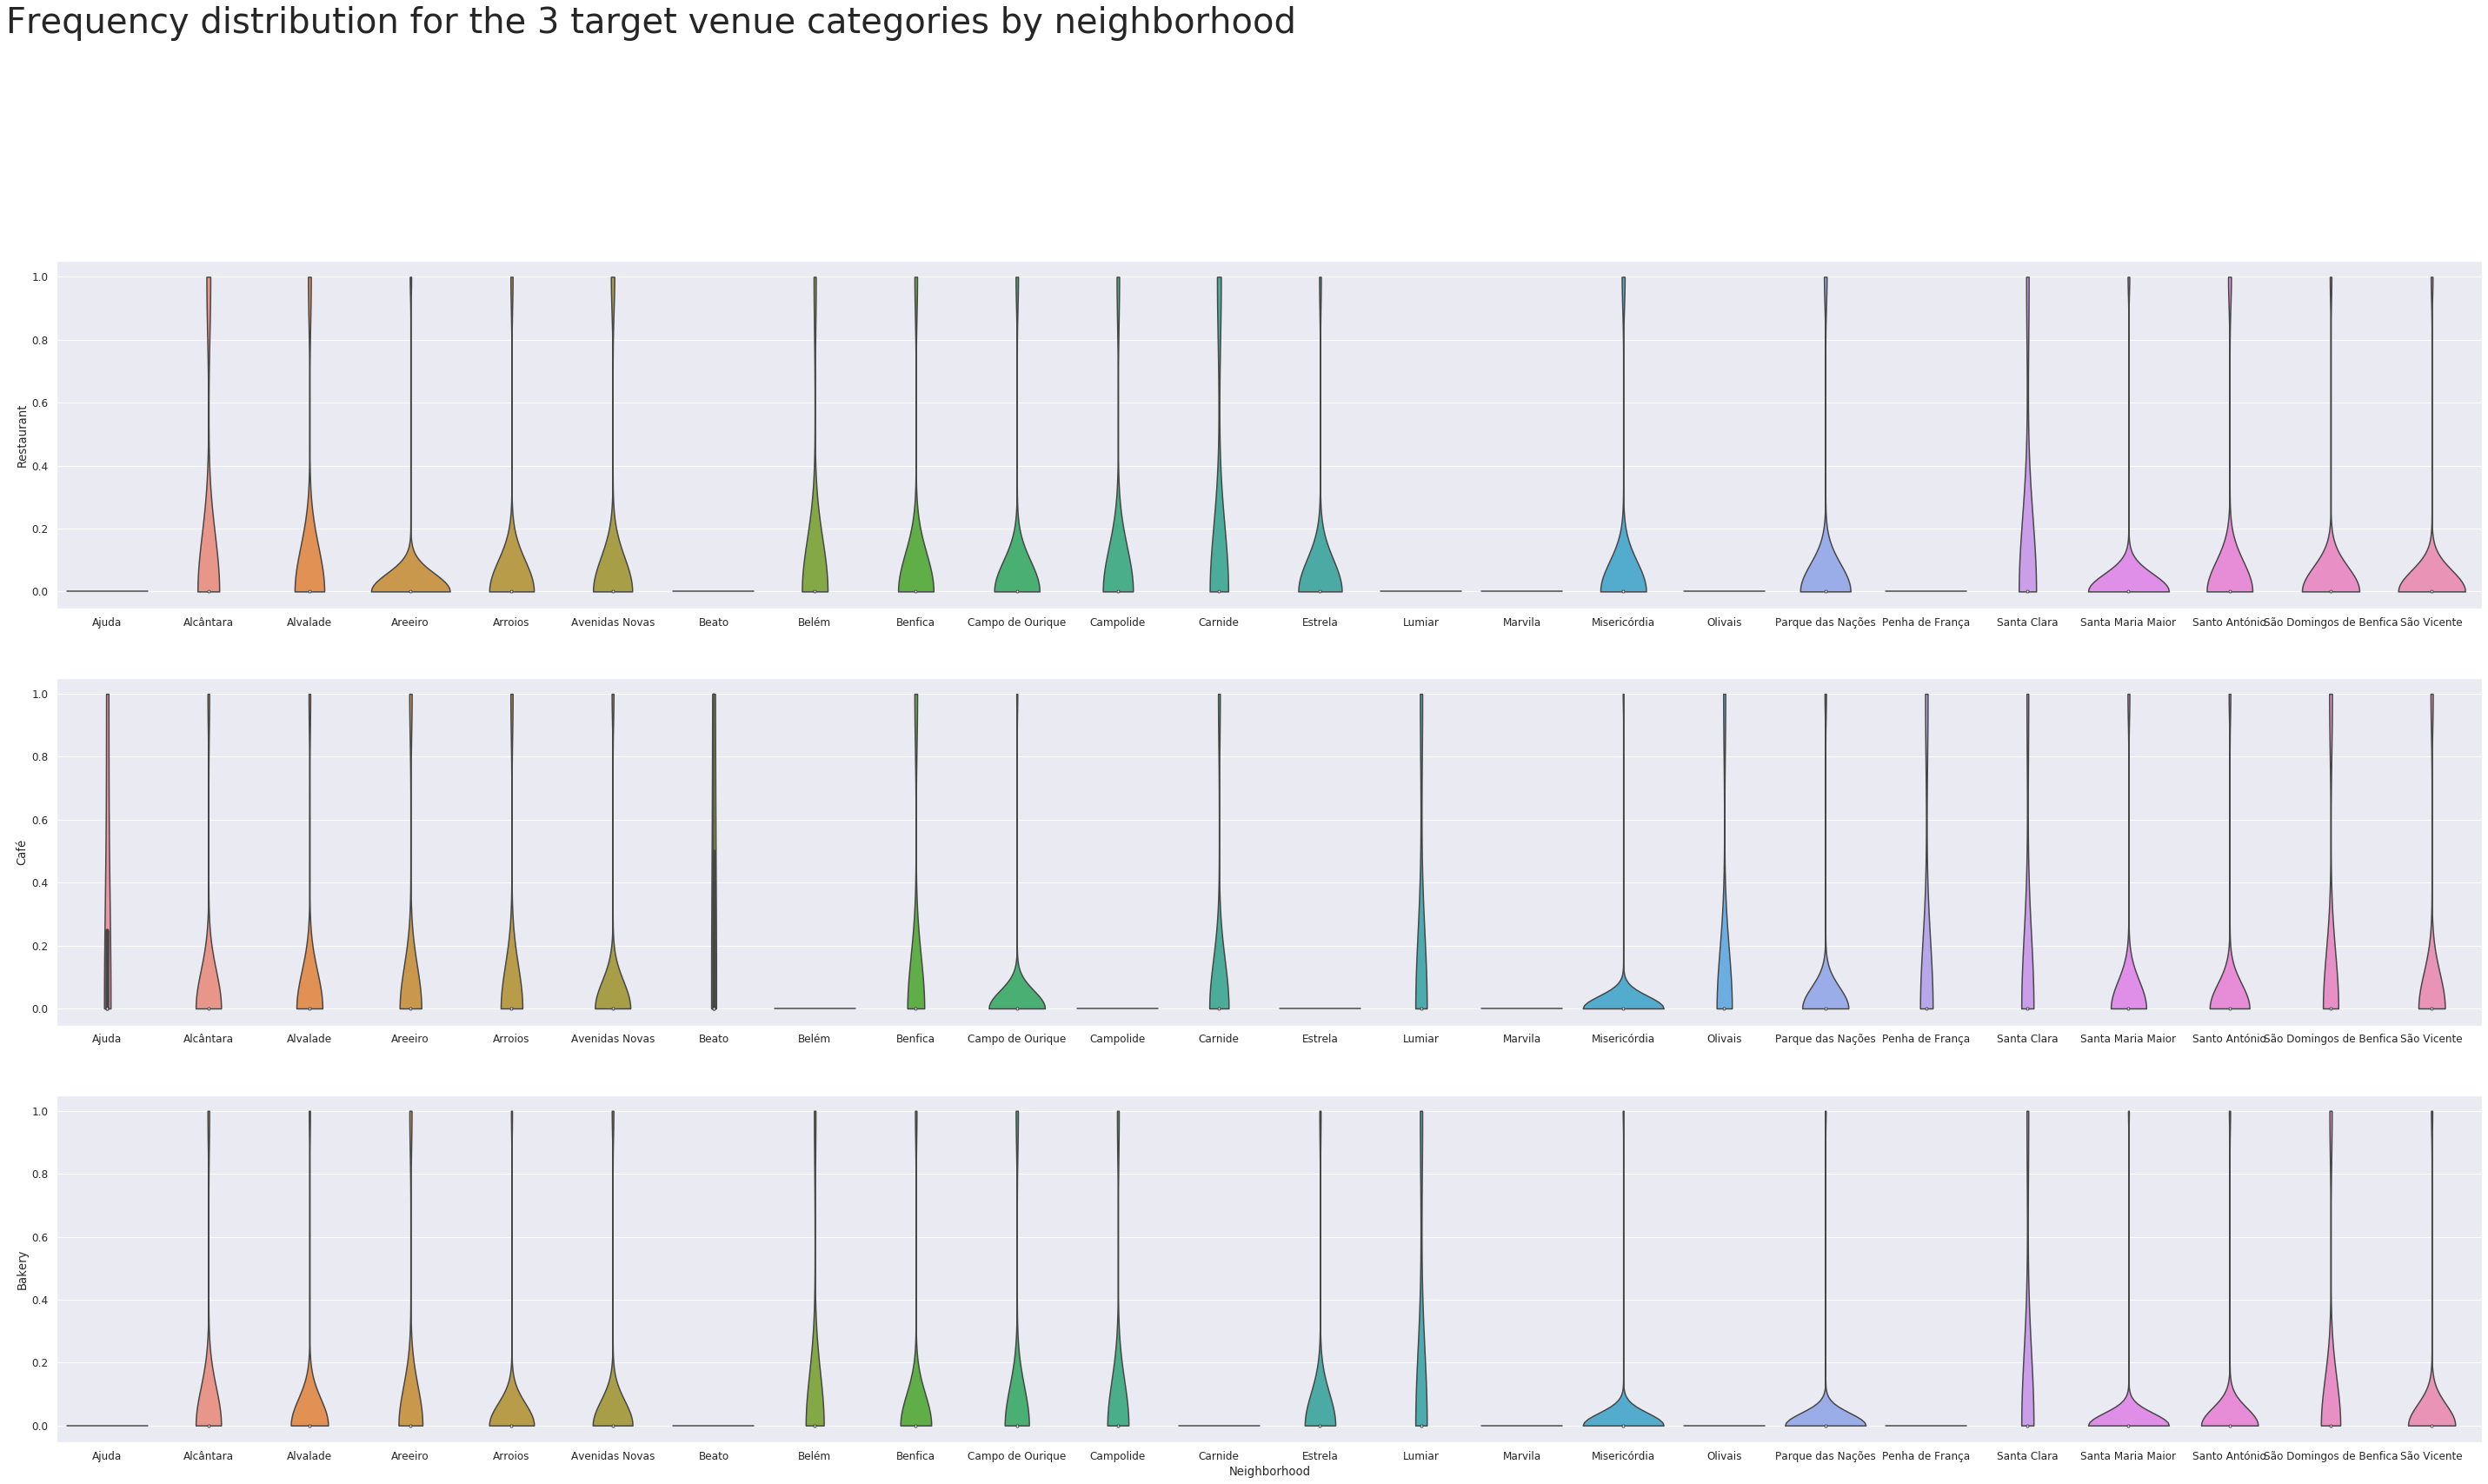

In [103]:
# Categorical plot
# Explore a plot of this data (a violin plot is used which is a density estimation of the underlying distribution).
# The top 3 venue types as specified by the client for each neighborhood are used for the plotting.
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)

ax = plt.subplot(3,1,1)
sns.violinplot(x="Neighborhood", y="Restaurant", data=downtown_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(3,1,2)
sns.violinplot(x="Neighborhood", y="Café", data=downtown_onehot, cut=0);
plt.xlabel("")

plt.subplot(3,1,3)
sns.violinplot(x="Neighborhood", y="Bakery", data=downtown_onehot, cut=0);

ax.text(-1.0, 3.1, 'Frequency distribution for the 3 target venue categories by neighborhood', fontsize=40)
plt.savefig ("Distribution_Frequency_Venues_3_categories.png", dpi=260)
plt.show()

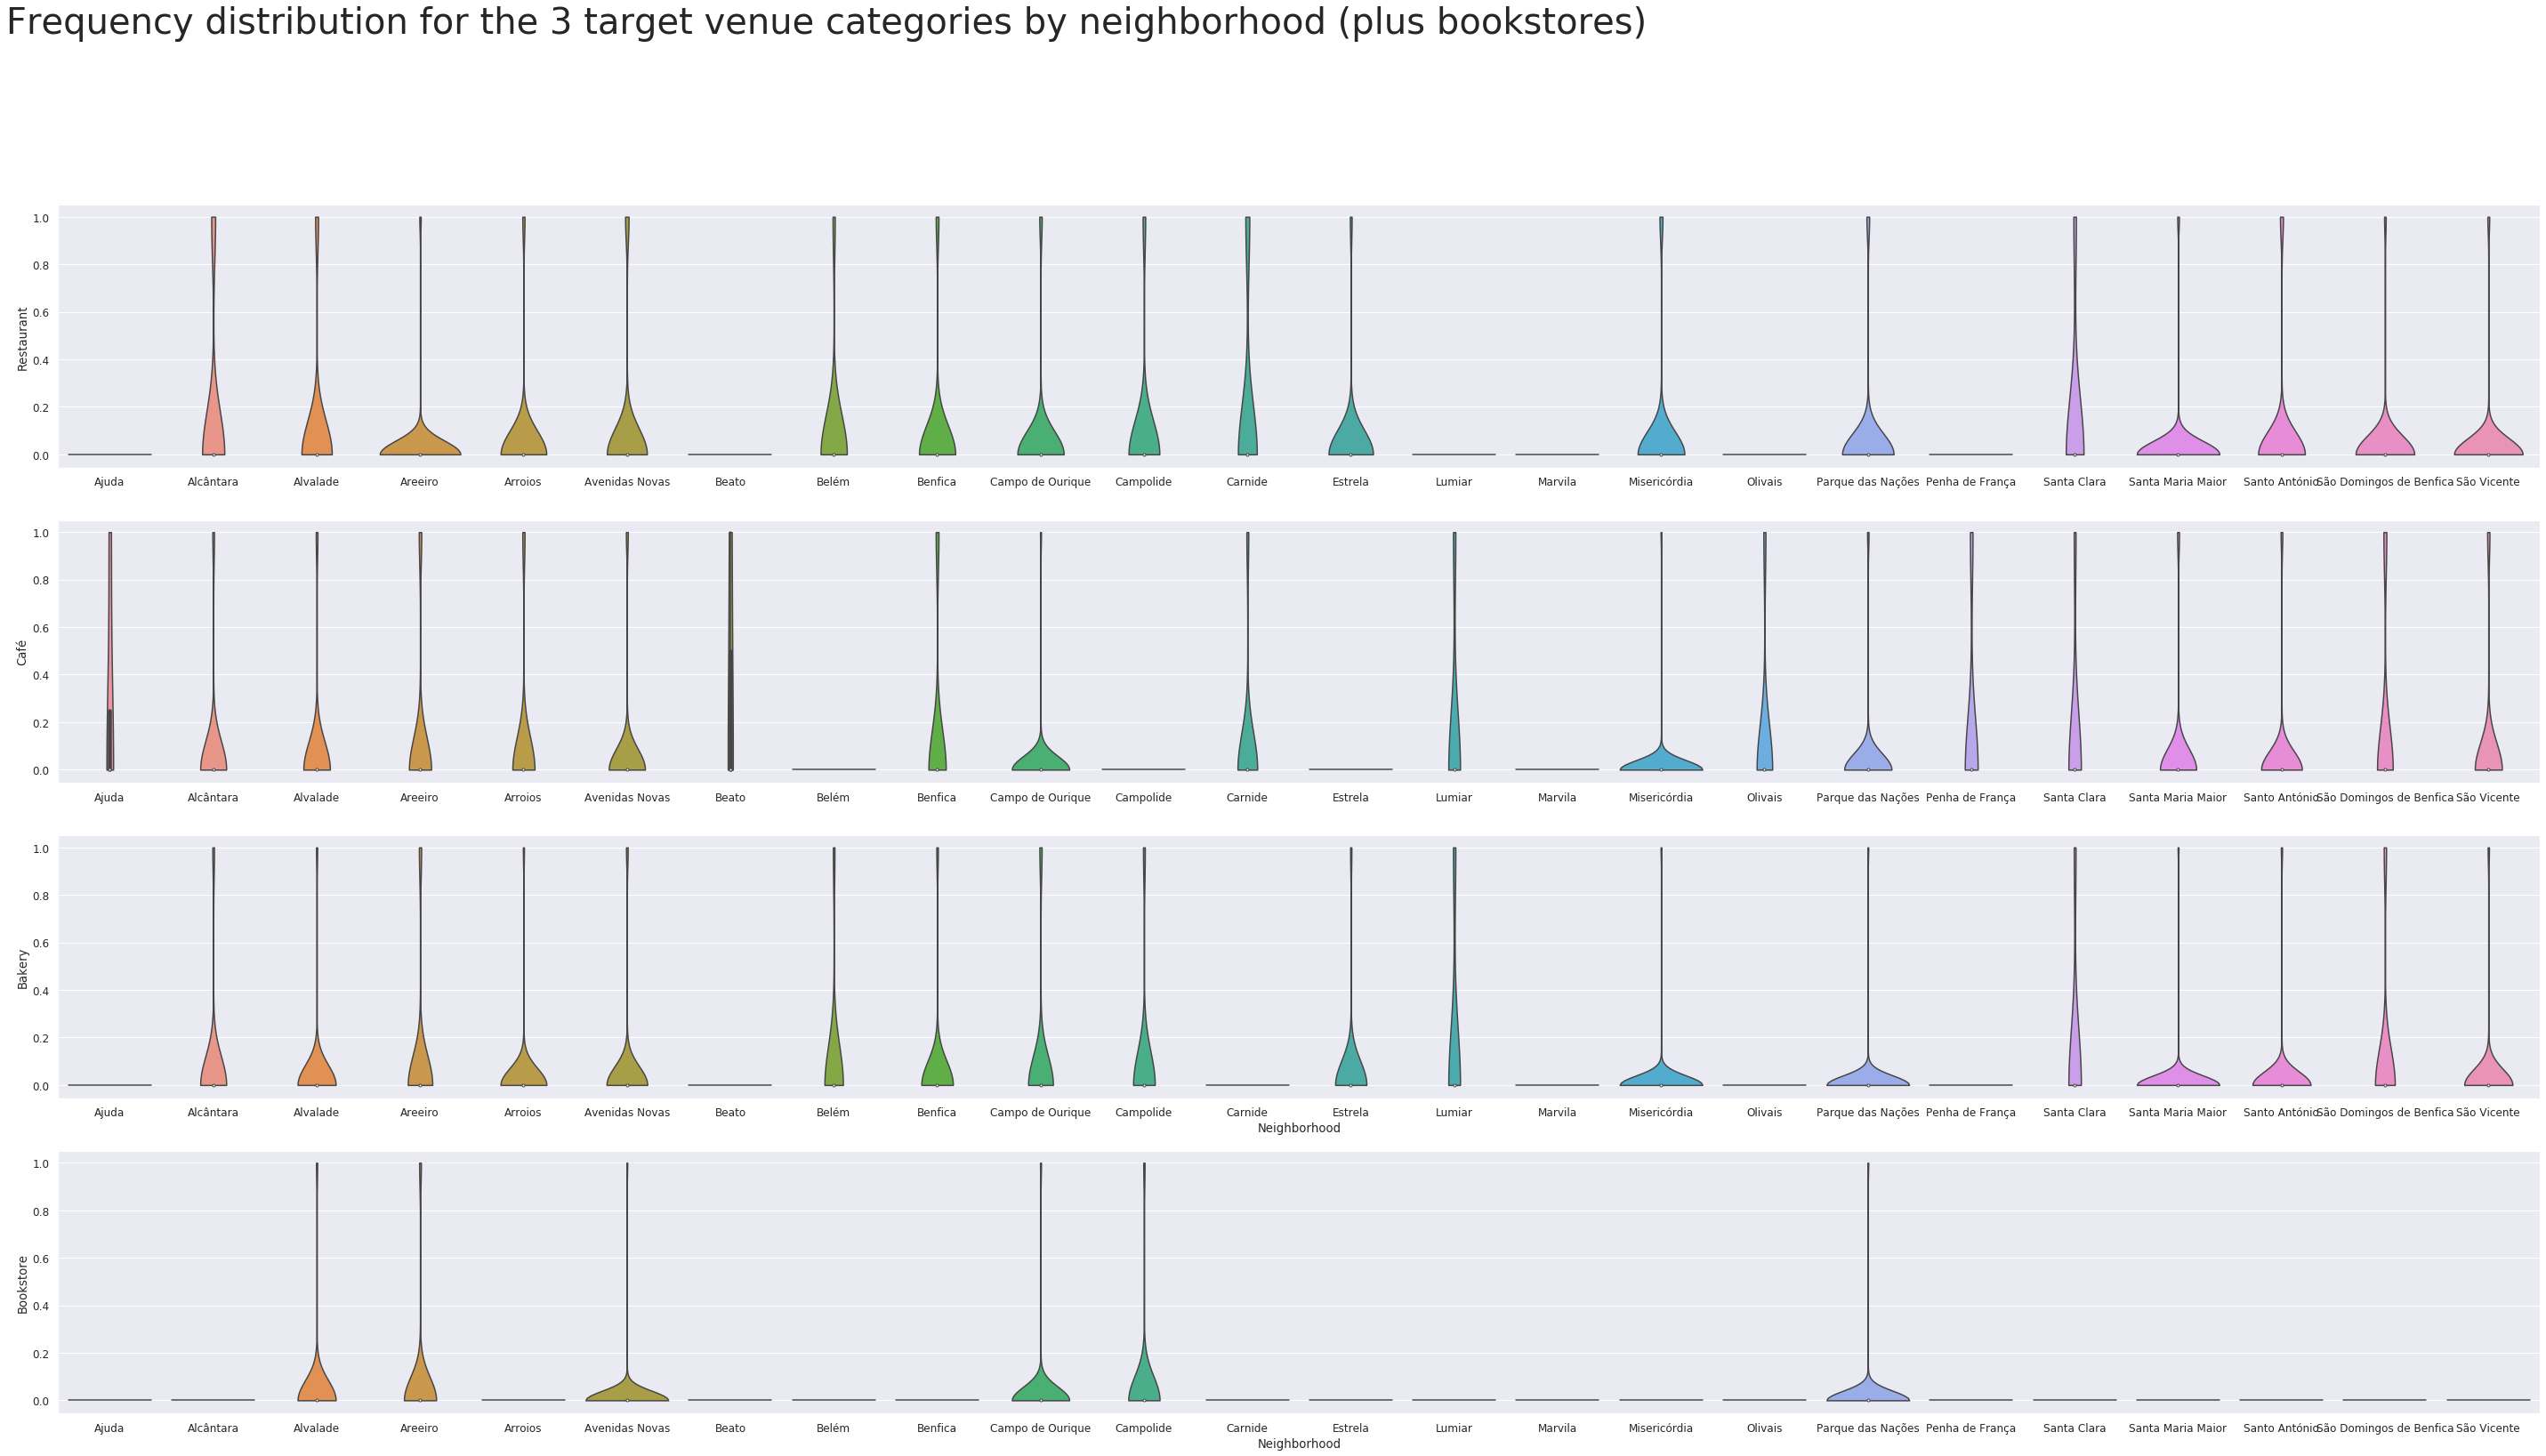

In [102]:
fig = plt.figure(figsize=(50,25))
sns.set(font_scale=1.1)

ax = plt.subplot(4,1,1)
sns.violinplot(x="Neighborhood", y="Restaurant", data=downtown_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(4,1,2)
sns.violinplot(x="Neighborhood", y="Café", data=downtown_onehot, cut=0);
plt.xlabel("")

plt.subplot(4,1,3)
sns.violinplot(x="Neighborhood", y="Bakery", data=downtown_onehot, cut=0);

plt.subplot(4,1,4)
sns.violinplot(x="Neighborhood", y="Bookstore", data=downtown_onehot, cut=0);

ax.text(-1.0, 3.1, 'Frequency distribution for the 3 target venue categories by neighborhood (plus bookstores)', fontsize=40)
plt.savefig ("Distribution_Frequency_Venues_3_categories.png", dpi=240)
plt.show()

So our candidates are 
* Alvalade
* Areeiro
* Avenidas Novas
* Campo de Ourique
* Campolide
* Parque das Nações

In [88]:
violin_data = ['Alvalade', 'Areeiro', 'Avenidas Novas', 'Campo de Ourique', 'Campolide', 'Parque das Nações']

There a re still a lot of neighborhoods to analyse. We have other source data to include in our analysis.
Where yourger people live. So let display it on the map.

In [89]:
def population_map(center = [latitude, longitude], zoom = 12):
    map = folium.Map(location = center, zoom_start = zoom)

    # choropleth map without data to outline the neighborhoods    
    choropleth = folium.Choropleth(
        geo_data = neighborhoods_json,#neighborhoods_json,
        data = df2,
        columns = ['Neighborhood', 'Total'],
        key_on ='feature.properties.NOME',
        name = 'choropleth',
        fill_color = 'YlOrRd',
        fill_opacity = 0.7, 
        line_opacity = 0.3,
        legend_name = 'Total of younger Population distribution',
        line_color = 'black',
        highlight = True,
    ).add_to(map)

    return map

younger_pop_map = population_map()

# add approximate neighborhood center markers to map
for lat, lng, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        fill=True,
        parse_html=False,
        color='blue'
    ).add_to(younger_pop_map)
    
# display map
younger_pop_map

In [90]:
df2.head()

,Neighborhood,Old Neighborhood,real estate value,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years,real estate score,population score,total score,Latitude,Longitude
0,Ajuda,Ajuda,3205,15584,617,777,960,1079,0.666741,0.204853,0.871594,38.711312,-9.198212
1,Alcântara,Alcântara,3127,13943,511,623,950,1044,0.650515,0.183282,0.833797,38.705996,-9.182754
2,Alvalade,"Alvalade, Campo Grande, São João de Brito",3547,31110,1287,1586,1920,2161,0.737888,0.408945,1.146832,38.747756,-9.139389
3,Areeiro,"Alto do Pina, São João de Deus",3167,20131,874,1125,1324,1361,0.658836,0.264624,0.923460,38.744617,-9.134370
4,Arroios,"Anjos, Pena, São Jorge de Arroios",3274,32262,1186,1760,2573,2804,0.681095,0.424088,1.105183,38.731691,-9.137314


In [91]:
df2['real estate score'] = df2['real estate value'].apply(lambda value: 0.7 * value/df2['real estate value'].mean())
df2['population score']  = df2['Total'].apply(lambda value: 0.3 * value/df2['Total'].mean())
df2['total score'] = df2['population score'] + df2['real estate score']

In [92]:
def population_map(center = [latitude, longitude], zoom = 12):
    map = folium.Map(location = center, zoom_start = zoom)

    # choropleth map without data to outline the neighborhoods    
    choropleth = folium.Choropleth(
        geo_data = neighborhoods_json,#neighborhoods_json,
        data = df2,
        columns = ['Neighborhood', 'total score'],
        key_on ='feature.properties.NOME',
        name = 'choropleth',
        fill_color = 'YlOrRd',
        fill_opacity = 0.7, 
        line_opacity = 0.3,
        legend_name = 'Best score',
        line_color = 'black',
        highlight = True,
    ).add_to(map)

    return map

younger_pop_map = population_map()

# add approximate neighborhood center markers to map
for lat, lng, neighborhood in zip(df2['Latitude'], df2['Longitude'], df2['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        fill=True,
        parse_html=False,
        color='blue'
    ).add_to(younger_pop_map)
    
# display map
younger_pop_map

In [93]:
df2.head()

,Neighborhood,Old Neighborhood,real estate value,Total,15 - 19 years,20 - 24 years,25 - 29 years,30 - 34 years,real estate score,population score,total score,Latitude,Longitude
0,Ajuda,Ajuda,3205,15584,617,777,960,1079,0.666741,0.204853,0.871594,38.711312,-9.198212
1,Alcântara,Alcântara,3127,13943,511,623,950,1044,0.650515,0.183282,0.833797,38.705996,-9.182754
2,Alvalade,"Alvalade, Campo Grande, São João de Brito",3547,31110,1287,1586,1920,2161,0.737888,0.408945,1.146832,38.747756,-9.139389
3,Areeiro,"Alto do Pina, São João de Deus",3167,20131,874,1125,1324,1361,0.658836,0.264624,0.923460,38.744617,-9.134370
4,Arroios,"Anjos, Pena, São Jorge de Arroios",3274,32262,1186,1760,2573,2804,0.681095,0.424088,1.105183,38.731691,-9.137314


In [94]:
df2.set_index(df2.Neighborhood, inplace = True)

In [95]:
df3 = df2.loc[violin_data]

In [96]:
def population_map(center = [latitude, longitude], zoom = 12):
    map = folium.Map(location = center, zoom_start = zoom)

    # choropleth map without data to outline the neighborhoods    
    choropleth = folium.Choropleth(
        geo_data = neighborhoods_json,
        data = df2,
        columns = ['Neighborhood', 'total score'],
        key_on ='feature.properties.NOME',
        name = 'choropleth',
        fill_color = 'YlOrRd',
        fill_opacity = 0.7, 
        line_opacity = 0.3,
        legend_name = 'Best score',
        line_color = 'black',
        highlight = True,
    ).add_to(map)

    return map

younger_pop_map = population_map()

# add approximate neighborhood center markers to map

# display map

for lat, lng, neighborhood in zip(df3['Latitude'], df3['Longitude'], df3['Neighborhood']):
    folium.CircleMarker(
        location=[lat, lng],
        radius=20,
        fill=True,
        parse_html=True,
        color='green',
        fill_color='#3186cc'
    ).add_to(younger_pop_map)
    
younger_pop_map

In [97]:
m = folium.Map(
    location=[latitude, longitude],
    zoom_start=12  # Limited levels of zoom for free Mapbox tiles.
)

folium.GeoJson(
   neighborhoods_json,
    name='geojson'
).add_to(m)
m